In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# Download necessary NLTK tools
nltk.download('vader_lexicon')
nltk.download('stopwords')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tes's\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tes's\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
# Load CSV file
df = pd.read_csv('../data/raw_analyst_ratings.csv')  # adjust path based on where you store it

# Show structure
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [6]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='mixed')

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check for nulls
df.isnull().sum()

C:\Users\tes's\AppData\Local\Temp\ipykernel_12240\2221933505.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'], format='mixed')


Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


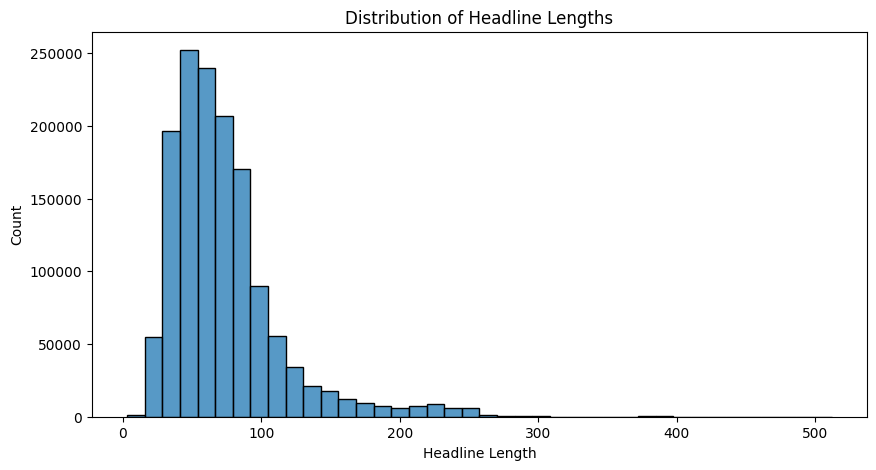

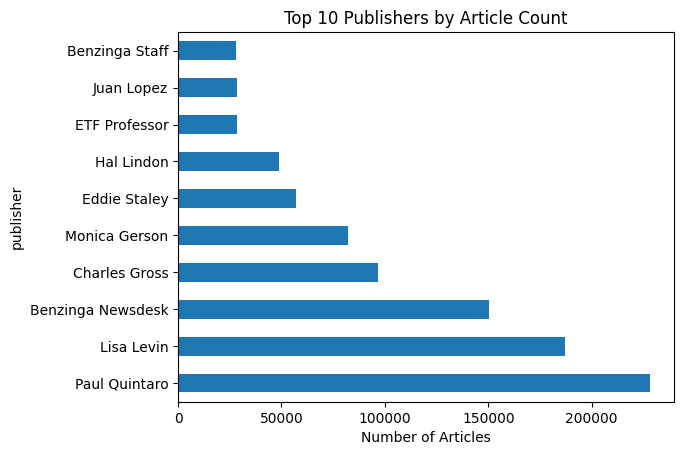

In [7]:
# Headline length
df['headline_length'] = df['headline'].apply(len)

# Summary stats
print(df['headline_length'].describe())

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=40)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Count')
plt.show()

# Article count per publisher
publisher_counts = df['publisher'].value_counts()
publisher_counts.head(10).plot(kind='barh')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Number of Articles')
plt.show()


In [9]:
print(df['date'].dtype)

object


In [11]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

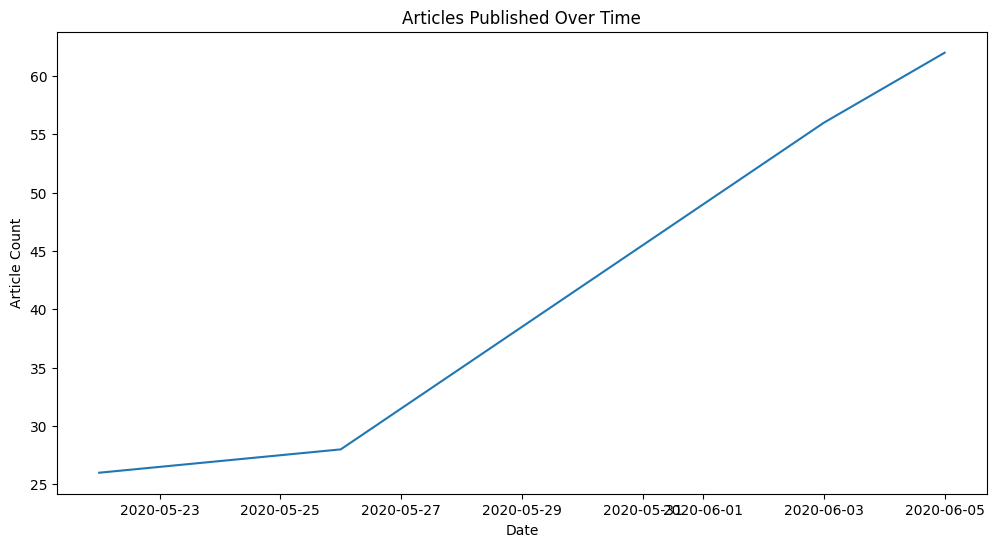

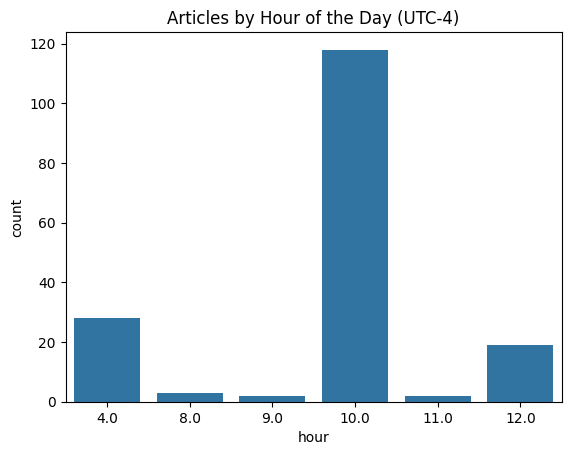

In [12]:
# Articles over time
df['date_only'] = df['date'].dt.date

articles_per_day = df.groupby('date_only').size()
articles_per_day.plot(figsize=(12, 6))
plt.title("Articles Published Over Time")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.show()

# Publishing time
df['hour'] = df['date'].dt.hour
sns.countplot(data=df, x='hour')
plt.title('Articles by Hour of the Day (UTC-4)')
plt.show()

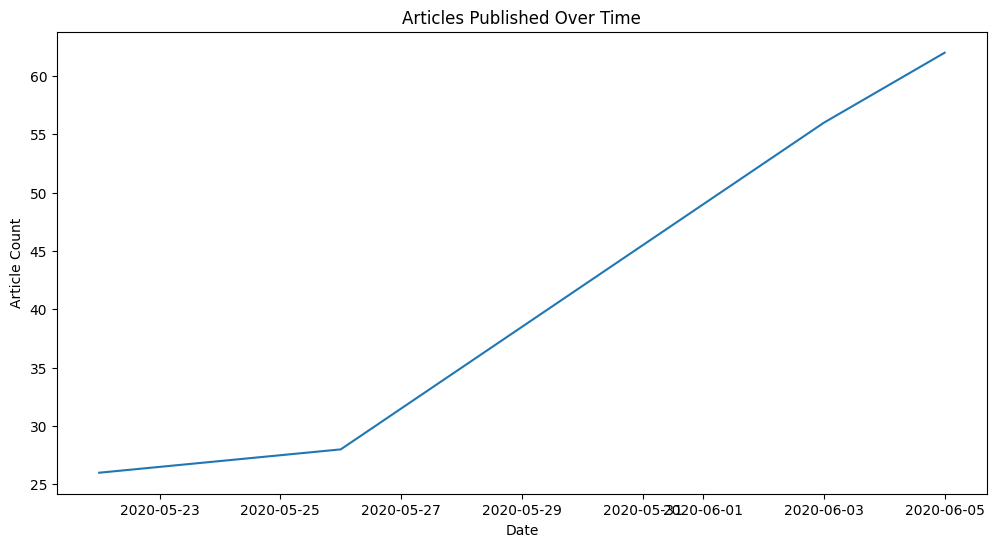

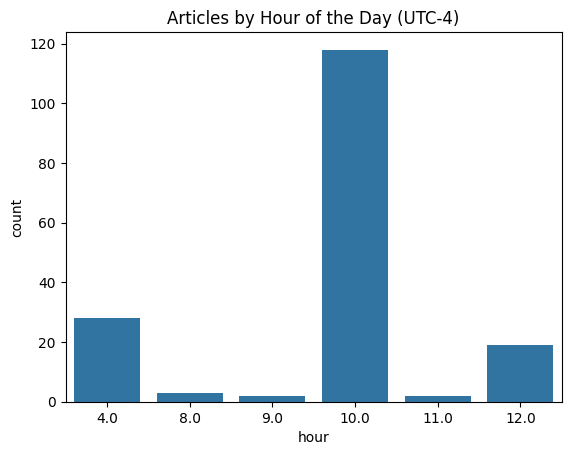

In [13]:
# Articles over time
df['date_only'] = df['date'].dt.date

articles_per_day = df.groupby('date_only').size()
articles_per_day.plot(figsize=(12, 6))
plt.title("Articles Published Over Time")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.show()

# Publishing time
df['hour'] = df['date'].dt.hour
sns.countplot(data=df, x='hour')
plt.title('Articles by Hour of the Day (UTC-4)')
plt.show()


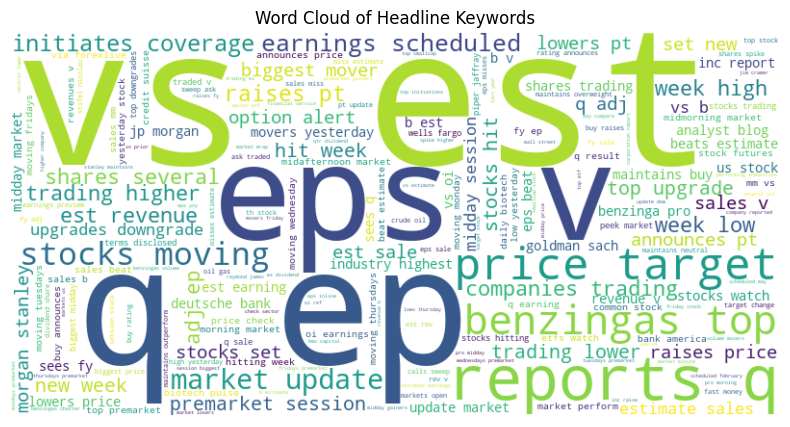

In [14]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_headline'] = df['headline'].apply(clean_text)

# Word Cloud
text = ' '.join(df['cleaned_headline'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Headline Keywords")
plt.show()


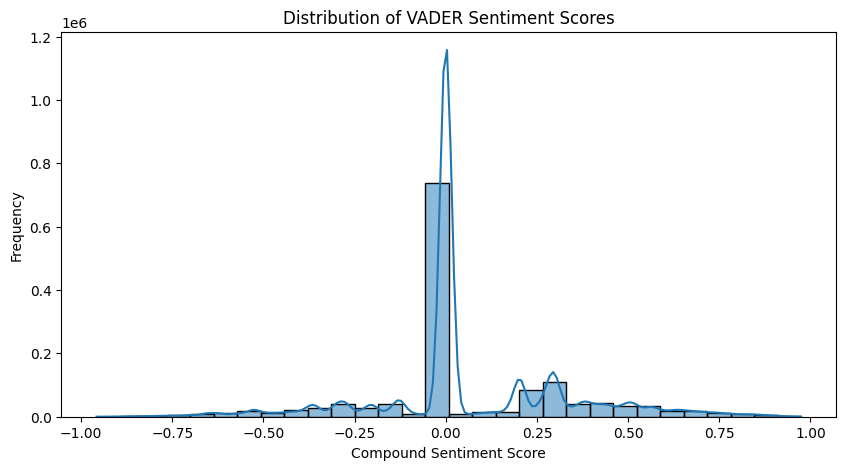

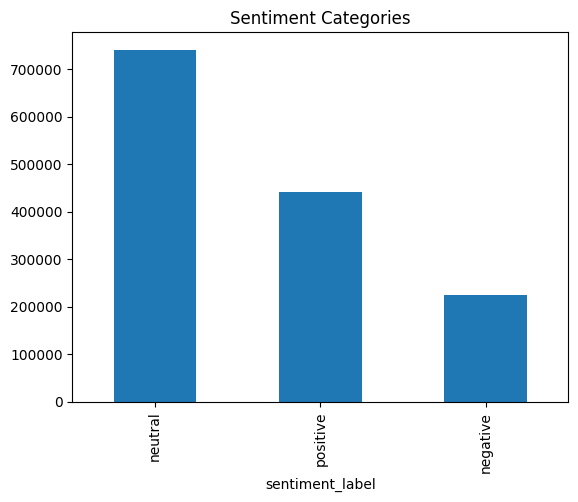

In [16]:
# VADER Sentiment Analysis
sid = SentimentIntensityAnalyzer()

df['sentiment'] = df['headline'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title("Distribution of VADER Sentiment Scores")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Classify sentiment
def sentiment_class(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment'].apply(sentiment_class)
df['sentiment_label'].value_counts().plot(kind='bar')
plt.title("Sentiment Categories")
plt.show()


In [17]:
df.to_csv('../data/FNSPID_processed.csv', index=False)